<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: white; font-size:100%; text-align:left">

<h1 align="center"><font color='#DAA520'>💡 Generative-Based modols (VAE) for ZSL :</font></h1>
    


*inhales deeply* Alright, let’s dive into the world of generative-based methods for zero-shot learning (ZSL) with a clear mind! As a computer vision developer with extensive experience in this domain, I’ll walk you through the key concepts, focusing on the training and inference phases, while keeping it intuitive and precise.

Generative-based methods for zero-shot learning aim to tackle the challenge of recognizing classes that were never seen during training by leveraging semantic information (like class attributes or text descriptions) and generating synthetic representations of those unseen classes. These methods have gained traction because they bridge the gap between seen and unseen classes using probabilistic or generative models. Let’s break it down into the two phases: training and inference.

**Training Phase**
In the training phase, the goal is to learn a generative model that can capture the underlying distribution of visual features conditioned on semantic information (e.g., attributes, word embeddings, or text descriptions) for the *seen classes*. Here’s how it typically works:

1. **Data Setup**: You start with a dataset of seen classes, where each class has visual features (e.g., extracted from a pre-trained CNN like ResNet) and corresponding semantic descriptions (e.g., attribute vectors or word embeddings from models like Word2Vec or BERT).

2. **Model Architecture**: A generative model—commonly a Variational Autoencoder (VAE), Generative Adversarial Network (GAN), or a hybrid like a Conditional GAN—is trained. For example:
   - In a **Conditional VAE**, the encoder learns to map visual features and their semantic embeddings into a latent space, while the decoder reconstructs the visual features conditioned on the semantic input.
   - In a **Conditional GAN**, a generator produces synthetic visual features from semantic embeddings and noise, while a discriminator ensures these features resemble real ones.

3. **Objective**: The model is optimized to minimize reconstruction loss (for VAEs) or adversarial loss (for GANs), ensuring that the generated features align with the distribution of real features for seen classes. Regularization terms might be added to enforce alignment between the visual and semantic spaces.

4. **Outcome**: By the end of training, the generative model can produce plausible visual feature representations for any class given its semantic description—even for classes it hasn’t seen. This is the magic of generalization in ZSL!

For instance, if the seen classes include "cat" (attributes: furry, whiskers) and "dog" (attributes: furry, loyal), the model learns how "furry" or "whiskers" translate into visual features.

**Inference Phase**
Now, let’s move to the inference phase, where the trained generative model shines by enabling recognition of *unseen classes*. Here’s the process:

1. **Input**: You’re given semantic descriptions (e.g., attributes or embeddings) of unseen classes—like "zebra" (attributes: striped, horse-like)—but no visual data for these classes.

2. **Feature Generation**: The trained generative model takes the semantic description of the unseen class and generates synthetic visual features. For example:
   - In a VAE, you sample from the latent space conditioned on the "zebra" attributes.
   - In a GAN, the generator produces "zebra" features directly from the semantic input and noise.

3. **Classifier Training**: Using these synthetic features, you train a simple classifier (e.g., softmax or nearest-neighbor) on the generated data for unseen classes. In some cases, you might combine generated features for unseen classes with real features from seen classes (for generalized ZSL).

4. **Prediction**: When a new test image comes in, its visual features are extracted (via the same pre-trained CNN) and passed to the classifier, which predicts whether it belongs to an unseen class (like "zebra") or a seen class (like "cat").


[Presentation_Slides](https://gamma.app/docs/Generative-Methods-for-Zero-Shot-Learning-The-Power-of-VAEs-5j1snunpsed7xja)


<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">📌  Step 1: Setup and Data Preparation
</h1>  
     
</div>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from random import sample

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10 data loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define seen and unseen classes
seen_classes = [0, 1, 2, 3, 4, 5, 6, 7]  # airplane, automobile, bird, cat, deer, dog, frog, horse
unseen_classes = [8, 9]  # ship, truck

# Filter datasets
train_indices = [i for i, (_, label) in enumerate(trainset) if label in seen_classes]
test_indices = [i for i, (_, label) in enumerate(testset) if label in unseen_classes]
seen_trainset = Subset(trainset, train_indices)
unseen_testset = Subset(testset, test_indices)

# Dataloader
train_loader = DataLoader(seen_trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(unseen_testset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 37.9MB/s]


<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">📌 Step 2: Class Descriptions and BERT Embeddings
</h1>  
     
</div>

In [2]:
# Class descriptions
class_descriptions = {
    0: "An aircraft designed for air travel, such as a plane flying in the sky.",
    1: "A car or vehicle commonly used on roads with four wheels.",
    2: "A small flying creature with feathers and wings, known as a bird.",
    3: "A domestic feline animal that often meows and is kept as a pet.",
    4: "A forest-dwelling mammal with antlers, typically known as a deer.",
    5: "A loyal domesticated animal that barks, commonly called a dog.",
    6: "A green amphibian that hops and has smooth skin, called a frog.",
    7: "A large four-legged animal used for riding or work, known as a horse.",
    8: "A large sea vessel that travels on water, such as a cargo or cruise ship.",
    9: "A large vehicle used for transporting heavy loads, typically a truck."
}

# BERT embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

def get_bert_embedding(description):
    inputs = tokenizer(description, return_tensors='pt', padding=True, truncation=True, max_length=20).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[0, 0, :]

class_embeddings = {cls: get_bert_embedding(desc) for cls, desc in class_descriptions.items()}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">📌 Step 3.1: Define and Train the VAE
</h1>  
     
</div>

In [3]:
# Updated VAE
class VAE(nn.Module):
    def __init__(self, img_channels=3, latent_dim=128, embedding_dim=768):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: Image processing only
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, 2, 1),                               # (64, 3, 32, 32) -> (64, 32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),                                         # (64, 32, 16, 16) -> (64, 64, 8, 8)
            nn.ReLU(),
            nn.Flatten(),
            )                                                                   # Output: (batch_size, 64 * 8 * 8) = (64, 4096)

        # Combine image features and embeddings
        self.fc_mu = nn.Linear(64 * 8 * 8 + embedding_dim, latent_dim)          # (64, 4096) -> (64, 128)
        self.fc_logvar = nn.Linear(64 * 8 * 8 + embedding_dim, latent_dim)      # (64, 4864) -> (64, 128)


        # Decoder: Conditioned on embedding
        self.decoder_input = nn.Linear(latent_dim + embedding_dim, 256)        # (64, 128 + 768) -> (64, 256)
        self.decoder = nn.Sequential(
            nn.Linear(256, 64 * 8 * 8),                                        # (64, 256) -> (64, 4096)
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),                                        # (64, 4096) -> (64, 64, 8, 8)
            nn.ConvTranspose2d(64, 32, 4, 2, 1),                                # (64, 64, 8, 8) -> (64, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, img_channels, 4, 2, 1),                      # (64, 32, 16, 16) -> (64, 3, 32, 32)
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)                                           # logvar = log(σ²) → σ = exp(0.5 * logvar)
        eps = torch.randn_like(std)                                             # Noise N(0, 1)
        return mu + eps * std                                                   # Sample: N(μ, σ²)

    def forward(self, x, embedding):
        # Encode image
        img_features = self.encoder(x)                                          # (64, 4096)
        # Combine with embedding
        combined = torch.cat([img_features, embedding], dim=1)                  # (64, 4096 + 768) = (64, 4864)

        # Latent space
        mu = self.fc_mu(combined)                                               # (64, 128)
        logvar = self.fc_logvar(combined)                                       # (64, 128)
        z = self.reparameterize(mu, logvar)                                     # (64, 128)

        # Decode with embedding
        z = torch.cat([z, embedding], dim=1)                                    # (64, 128 + 768) = (64, 896)
        recon_x = self.decoder(self.decoder_input(z))                           # (64, 3, 32, 32)
        return recon_x, mu, logvar

```
VAE Architecture Summary:
Input Image: torch.Size([64, 3, 32, 32])
Encoder Output (img_features): torch.Size([64, 4096])
Combined Features: torch.Size([64, 4864])
Latent mu: torch.Size([64, 128]), logvar: torch.Size([64, 128]), z: torch.Size([64, 128])
Decoder Input (z + embedding): torch.Size([64, 896])
Decoder Linear Output: torch.Size([64, 256])
Reconstructed Output: torch.Size([64, 3, 32, 32])
```

[VAE Shape Flow](https://drive.google.com/file/d/19NCGNbcWoTKc-c_3ycgswpbrcriH1IU8/view)

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)              </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">        Param # </span>┃<span style="font-weight: bold"> Connected to           </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">3</span>)      │              <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)           │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>)     │          <span style="color: #00af00; text-decoration-color: #00af00">1,568</span> │ image_input[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)         │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)       │         <span style="color: #00af00; text-decoration-color: #00af00">32,832</span> │ conv2d[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>)         │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4096</span>)           │              <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ conv2d_1[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_input           │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">768</span>)            │              <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ -                      │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (<span style="color: #0087ff; text-decoration-color: #0087ff">Concatenate</span>) │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4864</span>)           │              <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ flatten[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>],         │
│                           │                        │                │ embedding_input[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mu (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)            │        <span style="color: #00af00; text-decoration-color: #00af00">622,720</span> │ concatenate[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ logvar (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)            │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)            │        <span style="color: #00af00; text-decoration-color: #00af00">622,720</span> │ concatenate[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (<span style="color: #0087ff; text-decoration-color: #0087ff">Lambda</span>)           │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)            │              <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ mu[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>], logvar[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">896</span>)            │              <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ lambda[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>],          │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Concatenate</span>)             │                        │                │ embedding_input[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">256</span>)            │        <span style="color: #00af00; text-decoration-color: #00af00">229,632</span> │ concatenate_1[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)           │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4096</span>)           │      <span style="color: #00af00; text-decoration-color: #00af00">1,052,672</span> │ dense[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (<span style="color: #0087ff; text-decoration-color: #0087ff">Reshape</span>)         │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)       │              <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ dense_1[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>)     │         <span style="color: #00af00; text-decoration-color: #00af00">32,800</span> │ reshape[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]          │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">3</span>)      │          <span style="color: #00af00; text-decoration-color: #00af00">1,539</span> │ conv2d_transpose[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>] │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2DTranspose</span>)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘
</pre>

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Total params: </span><span style="color: #00af00; text-decoration-color: #00af00">2,596,483</span> (9.90 MB)
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Trainable params: </span><span style="color: #00af00; text-decoration-color: #00af00">2,596,483</span> (9.90 MB)
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Non-trainable params: </span><span style="color: #00af00; text-decoration-color: #00af00">0</span> (0.00 B)
</pre>

### Loss Function
For this VAE-based ZSL architecture, we use the **Evidence Lower Bound (ELBO)** loss, which consists of two terms:
1. **Reconstruction Loss**: Measures how well the decoder reconstructs the input visual features.
2. **KL Divergence**: Regularizes the latent space to follow a standard normal distribution.
$$
\mathcal{L}_{\text{VAE}} = \underbrace{ - \mathbb{E}_{q_\phi(z|x)} [ \log p_\theta(x|z) ] }_{\text{Reconstruction Loss}} + \underbrace{ D_{\text{KL}} \left( q_\phi(z|x) \parallel p(z) \right) }_{\text{KL Loss}}
$$



#### Why This Loss?
1. **Reconstruction Loss (MSE)**:
   - We use Mean Squared Error (MSE) between the reconstructed features (`recon_x`) and original features (`x`) because it directly optimizes the VAE to generate accurate visual features for seen classes.
   - In ZSL, high-quality feature reconstruction ensures that generated features for unseen classes (during inference) are plausible and align with the visual domain.

   **General Form (Expected Log-Likelihood):**

$$
\mathcal{L}_{\text{recon}} = - \mathbb{E}_{q_\phi(z|x)} \left[ \log p_\theta(x|z) \right]
$$

This is the **negative log-likelihood** of reconstructing \( x \) given latent representation \( z \).



**Choice of Likelihood Distribution**

This term depends on the output distribution assumed for the data:
- **Gaussian** for continuous-valued data (e.g., images normalized to [0,1])
- **Bernoulli** for binary-valued data (e.g., binarized MNIST)



I. **Gaussian Likelihood (common for regression or real-valued images):**

If you assume:

$$
p_\theta(x|z) = \mathcal{N}(x; \mu_\theta(z), \sigma^2 I)
$$

Then the log-likelihood becomes:

$$
\log p_\theta(x|z) = -\frac{1}{2\sigma^2} \| x - \mu_\theta(z) \|^2 + \text{const}
$$

So the **reconstruction loss** is equivalent to **mean squared error (MSE)**:

$$
\mathcal{L}_{\text{recon}} = \frac{1}{2\sigma^2} \| x - \hat{x} \|^2
$$

In practice (ignoring constant scaling), we use:

$$
\mathcal{L}_{\text{recon}} = \| x - \hat{x} \|^2
$$

or normalized version:

$$
\mathcal{L}_{\text{recon}} = \frac{1}{n} \sum_{i=1}^n (x_i - \hat{x}_i)^2
$$



II. **Bernoulli Likelihood (common for binary data):**

If:

$$
p_\theta(x|z) = \text{Bernoulli}(\hat{x})
$$

Then the reconstruction loss becomes the **binary cross-entropy (BCE)**:

$$
\mathcal{L}_{\text{recon}} = - \sum_{i=1}^n \left[ x_i \log \hat{x}_i + (1 - x_i) \log (1 - \hat{x}_i) \right]
$$

2. **KL Divergence**:
   - This term enforces a Gaussian prior on the latent space (mean 0, variance 1), preventing overfitting and ensuring smooth interpolation between classes.
   - For ZSL, a well-regularized latent space is critical—it allows the model to generalize from seen to unseen classes by sampling latent codes conditioned on semantic embeddings.

$$
D_{\mathrm{KL}} \left( q_\phi(z|x) \parallel \mathcal{N}(0, I) \right) = \frac{1}{2} \sum_{i=1}^d \left( \mu_i^2 + \sigma_i^2 - \log \sigma_i^2 - 1 \right)
$$

3. **Why ELBO?**
   - The ELBO balances reconstruction fidelity and latent space regularization, making the VAE both generative and probabilistic. This is perfect for ZSL, as we need to synthesize features for unseen classes while maintaining a structured latent space tied to semantic information.
   - Alternatives like pure MSE (without KL) would lead to overfitting, while adversarial losses (GAN-style) are harder to stabilize—VAE’s ELBO is simpler and more reliable for this task.

In [4]:
# Loss function (same as before)
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [5]:
# Training with scheduler
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

🔍 **What is `CosineAnnealingLR`**?

`CosineAnnealingLR` is a **learning rate scheduler** that reduces the learning rate following a **cosine curve**, starting from the initial learning rate and gradually decaying it **without abrupt changes**. It’s especially useful in **generative models** like VAEs, where smoother learning rate transitions can help with more stable and fine-grained convergence.

---

📉 **How It Works**
The learning rate `lr(t)` is updated at each epoch (or step) using a cosine formula:
$$
lr(t) = \eta_{min} + \frac{1}{2} (\eta_{max} - \eta_{min}) \left(1 + \cos\left(\frac{T_{cur}}{T_{max}} \pi\right)\right)
$$
Where:
- **`η_max`** is the initial learning rate
- **`η_min`** is the minimum learning rate
- **`T_cur`** is the number of epochs since the last restart
- **`T_max`** is the total number of epochs you want the cosine decay to last before restarting (optional restart)



In [6]:
for epoch in range(50):
    vae.train()
    total_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        embeddings = torch.stack([class_embeddings[cls.item()] for cls in labels]).to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images, embeddings)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset)}")

Epoch 1, Loss: 363.32015952148436
Epoch 2, Loss: 247.762795703125
Epoch 3, Loss: 223.49229892578126
Epoch 4, Loss: 212.25971923828126
Epoch 5, Loss: 206.06257424316405
Epoch 6, Loss: 202.56988486328126
Epoch 7, Loss: 200.4170600830078
Epoch 8, Loss: 198.58581916503906
Epoch 9, Loss: 197.1446491455078
Epoch 10, Loss: 195.6444713623047
Epoch 11, Loss: 194.53292133789063
Epoch 12, Loss: 193.28386760253906
Epoch 13, Loss: 192.56146416015625
Epoch 14, Loss: 191.56780615234376
Epoch 15, Loss: 190.79855502929686
Epoch 16, Loss: 190.1818809326172
Epoch 17, Loss: 189.16475490722655
Epoch 18, Loss: 188.61626853027343
Epoch 19, Loss: 188.10149755859376
Epoch 20, Loss: 187.4006671142578
Epoch 21, Loss: 186.85199873046875
Epoch 22, Loss: 186.4711966796875
Epoch 23, Loss: 185.9350267578125
Epoch 24, Loss: 185.444271875
Epoch 25, Loss: 184.99440339355468
Epoch 26, Loss: 184.7927182861328
Epoch 27, Loss: 184.24654321289063
Epoch 28, Loss: 183.84802521972657
Epoch 29, Loss: 183.48654272460936
Epoch 30,

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">📌 Step 3.2: Model Evaluation on Seen Classes
</h1>  
     
</div>

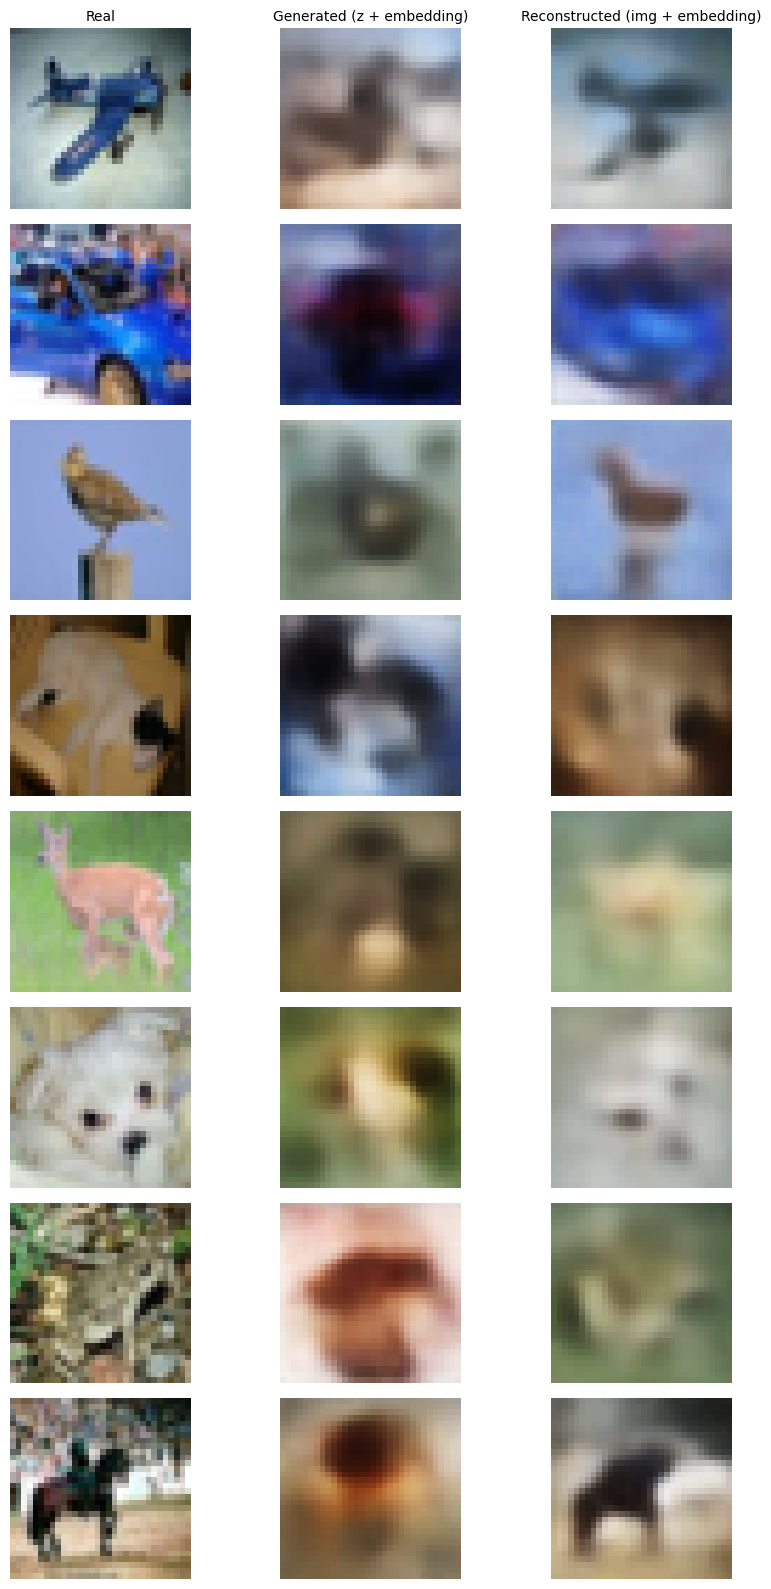

In [7]:
import random

# Define seen classes
seen_classes = [0, 1, 2, 3, 4, 5, 6, 7]  # airplane, automobile, bird, cat, deer, dog, frog, horse

# Class names for labeling (for clarity in visualization)
class_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse"
}

vae.eval()
num_classes = len(seen_classes)

fig, axes = plt.subplots(num_classes, 3, figsize=(3 * 3, num_classes * 2))

for i, cls in enumerate(seen_classes):
    # --- Get class embedding ---
    embedding = class_embeddings[cls].unsqueeze(0).to(device)

    # --- Get one real image for the class ---
    class_indices = [idx for idx in range(len(seen_trainset)) if trainset[seen_trainset.indices[idx]][1] == cls]
    idx = random.choice(class_indices)
    real_image, _ = trainset[seen_trainset.indices[idx]]
    real_image = real_image.unsqueeze(0).to(device)  # Shape: (1, 3, 32, 32)

    with torch.no_grad():
        # --- 1. Real image (denorm for display) ---
        img_real = real_image.squeeze().permute(1, 2, 0).cpu().numpy()
        img_real = img_real * 0.5 + 0.5
        img_real = np.clip(img_real, 0, 1)

        # --- 2. Pure sampled image ---
        z = torch.randn(1, vae.latent_dim).to(device)  # Sample from N(0, I)
        z_cond = torch.cat([z, embedding], dim=1)
        gen_image = vae.decoder(vae.decoder_input(z_cond)).squeeze().permute(1, 2, 0).cpu().numpy()
        gen_image = gen_image * 0.5 + 0.5
        gen_image = np.clip(gen_image, 0, 1)

        # --- 3. Reconstructed image ---
        embedding_repeated = embedding
        recon_image, _, _ = vae(real_image, embedding_repeated)
        recon_image = recon_image.squeeze().permute(1, 2, 0).cpu().numpy()
        recon_image = recon_image * 0.5 + 0.5
        recon_image = np.clip(recon_image, 0, 1)

    # --- Plotting ---
    titles = ["Real", "Generated (z + embedding)", "Reconstructed (img + embedding)"]
    images = [img_real, gen_image, recon_image]

    for j in range(3):
        axes[i, j].imshow(images[j])
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(titles[j], fontsize=10)
        if j == 0:
            axes[i, j].set_ylabel(class_names[cls], fontsize=10)

plt.tight_layout()
plt.show()


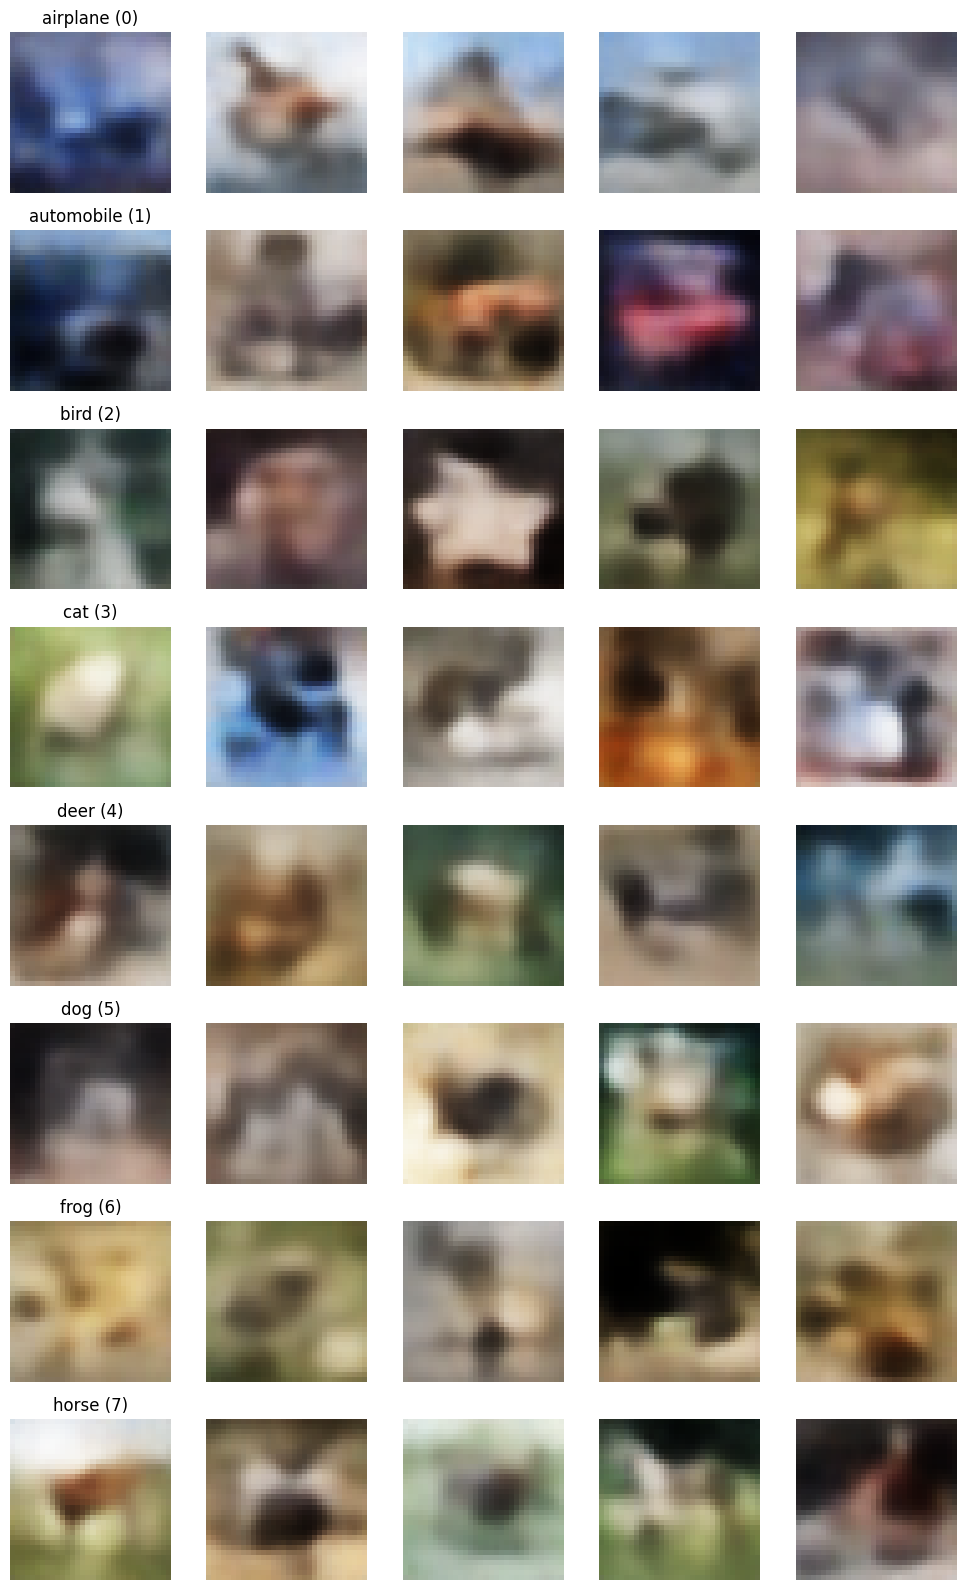

In [8]:
# Generate images for seen classes
vae.eval()
num_samples = 5  # Number of images to generate per class
fig, axes = plt.subplots(len(seen_classes), num_samples, figsize=(num_samples * 2, len(seen_classes) * 2))

for i, cls in enumerate(seen_classes):
    embedding = class_embeddings[cls].unsqueeze(0).to(device)  # Shape: (1, 768)
    with torch.no_grad():
        # Sample latent vectors
        z = torch.randn(num_samples, vae.latent_dim).to(device)  # Shape: (5, 128)
        embedding_repeated = embedding.repeat(num_samples, 1)   # Shape: (5, 768)
        z_cond = torch.cat([z, embedding_repeated], dim=1)      # Shape: (5, 128 + 768)
        generated_images = vae.decoder(vae.decoder_input(z_cond)).cpu()  # Shape: (5, 3, 32, 32)

    # Visualize generated images
    for j in range(num_samples):
        img = generated_images[j].permute(1, 2, 0).numpy()  # Shape: (32, 32, 3)
        img = img * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
        img = np.clip(img, 0, 1)  # Ensure values stay in valid range
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f"{class_names[cls]} ({cls})")

plt.tight_layout()
plt.show()

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">📌 Step 4: Generate and Visualize Images for Unseen Classes
</h1>  
     
</div>

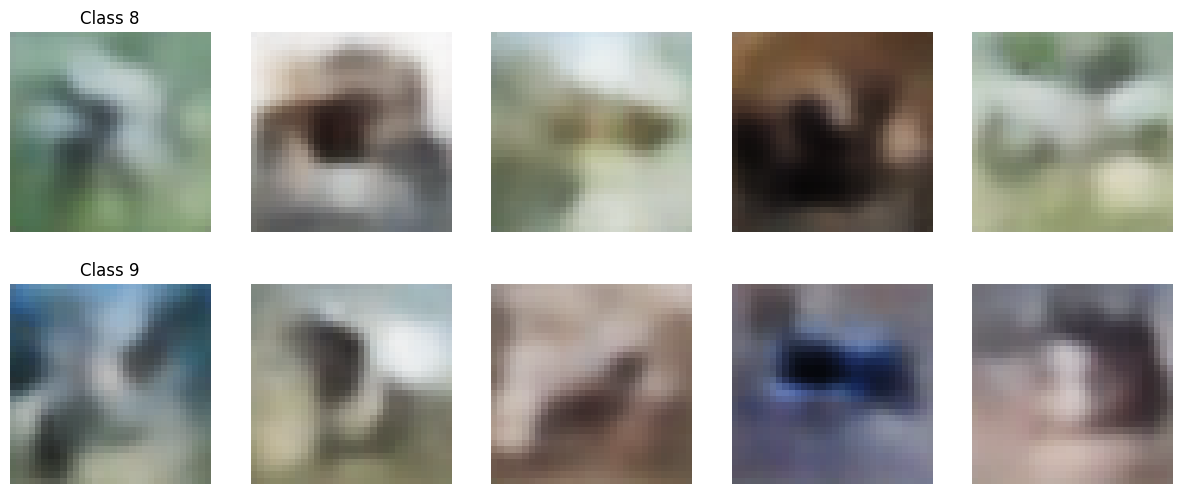

In [9]:
vae.eval()
num_samples = 5
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

for i, cls in enumerate(unseen_classes):
    embedding = class_embeddings[cls].unsqueeze(0).to(device)
    with torch.no_grad():
        z = torch.randn(num_samples, vae.latent_dim).to(device)
        z = torch.cat([z, embedding.repeat(num_samples, 1)], dim=1)
        generated_images = vae.decoder(vae.decoder_input(z)).cpu()

    for j in range(num_samples):
        img = generated_images[j].permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f"Class {cls}")
plt.show()

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">📌 Step 5: ZSL Evaluation (Similarity Between Generated and Real Images)
</h1>  
     
</div>

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


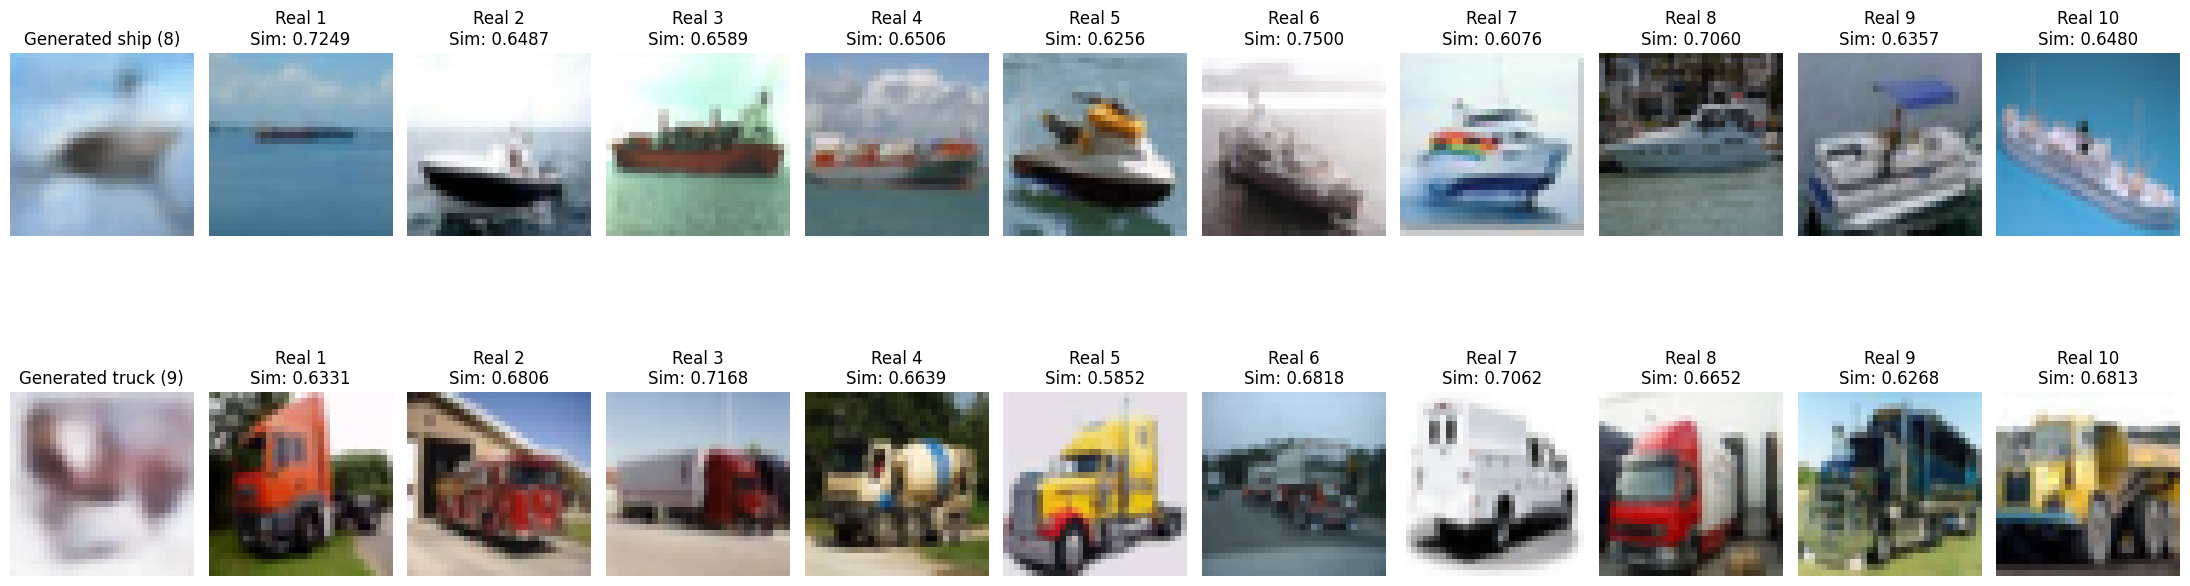

Class 8 (ship) Average Similarity (ResNet): 0.6656
Class 9 (truck) Average Similarity (ResNet): 0.6641


In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from random import sample

# Step 0: Setup ResNet for feature extraction
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()  # Remove classification layer to extract features
resnet = resnet.to(device)
resnet.eval()

# Transform to match ResNet input expectations
resnet_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ResNet's training normalization
                         std=[0.229, 0.224, 0.225])
])

# Cosine similarity between feature vectors
def cosine_similarity_feat(feat1, feat2):
    feat1, feat2 = feat1.flatten(), feat2.flatten()
    norm1, norm2 = np.linalg.norm(feat1), np.linalg.norm(feat2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return np.dot(feat1, feat2) / (norm1 * norm2)

# Extract features from an image (numpy array, [3, H, W])
def extract_features(img_np):
    img_tensor = torch.tensor(img_np).to(device)
    if img_tensor.dim() == 3:
        img_tensor = img_tensor.unsqueeze(0)
    img_tensor = resnet_transform(img_tensor)
    with torch.no_grad():
        features = resnet(img_tensor)
    return features.squeeze().cpu().numpy()

# Class names for clarity
class_names = {8: "ship", 9: "truck"}
unseen_classes = [8, 9]

# Step 1: Generate one image per unseen class
vae.eval()
generated_images = {}
for cls in unseen_classes:
    embedding = class_embeddings[cls].unsqueeze(0).to(device)
    with torch.no_grad():
        z = torch.randn(1, vae.latent_dim).to(device)
        z_cond = torch.cat([z, embedding], dim=1)
        gen_img = vae.decoder(vae.decoder_input(z_cond)).cpu().squeeze()
        gen_img = gen_img * 0.5 + 0.5
        generated_images[cls] = gen_img.numpy()

# Step 2: Select 10 random real images per unseen class
real_images = {cls: [] for cls in unseen_classes}
for cls in unseen_classes:
    class_indices = [i for i, (_, label) in enumerate(unseen_testset) if label == cls]
    selected_indices = sample(class_indices, min(10, len(class_indices)))
    for idx in selected_indices:
        img = unseen_testset[idx][0]
        img = img * 0.5 + 0.5
        real_images[cls].append(img.numpy())

# Step 3: Calculate cosine similarities in ResNet feature space
similarities = {cls: [] for cls in unseen_classes}
for cls in unseen_classes:
    gen_img = generated_images[cls]
    gen_feat = extract_features(gen_img)

    for real_img in real_images[cls]:
        real_feat = extract_features(real_img)
        sim = cosine_similarity_feat(gen_feat, real_feat)
        similarities[cls].append(sim)

# Step 4: Visualize generated and real images with similarities
fig, axes = plt.subplots(len(unseen_classes), 11, figsize=(22, 4 * len(unseen_classes)))

for i, cls in enumerate(unseen_classes):
    gen_img = generated_images[cls]
    axes[i, 0].imshow(gen_img.transpose(1, 2, 0))
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Generated {class_names[cls]} ({cls})")

    for j, (real_img, sim) in enumerate(zip(real_images[cls], similarities[cls])):
        axes[i, j + 1].imshow(real_img.transpose(1, 2, 0))
        axes[i, j + 1].axis('off')
        axes[i, j + 1].set_title(f"Real {j+1}\nSim: {sim:.4f}")

plt.tight_layout()
plt.show()

# Print average similarity for each class
for cls in unseen_classes:
    avg_sim = np.mean(similarities[cls])
    print(f"Class {cls} ({class_names[cls]}) Average Similarity (ResNet): {avg_sim:.4f}")


<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">📌 Step 6: Train Classifier on Generated Features
</h1>  
     
</div>

In [11]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import transforms
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from tqdm import tqdm

# ========== 1. Setup and Utilities ==========

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image preprocessing for ResNet18
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ResNet18 as feature extractor
resnet = resnet18(pretrained=True)
resnet.fc = nn.Identity()  # Remove classification head
resnet = resnet.to(device)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# ========== 2. Generate Synthetic Images for Unseen Classes ==========

def generate_synthetic_images(generator, attribute_dict, unseen_classes, n_per_class=1000):
    generator.eval()
    synthetic_images = []
    synthetic_labels = []

    for label in unseen_classes:
        attr_vector = attribute_dict[label]  # Should be torch.Tensor
        attr_vector = attr_vector.to(device)

        # Repeat attribute vector for batch generation
        attr_batch = attr_vector.unsqueeze(0).repeat(n_per_class, 1)

        # Sample from prior
        noise = torch.randn(n_per_class, generator.latent_dim).to(device)

        # Generate fake images (or features)
        with torch.no_grad():
            # Pass noise to reparameterize to get z
            z = generator.reparameterize(torch.zeros_like(noise), noise)

            # Concatenate z with the attribute batch
            z_cond = torch.cat([z, attr_batch], dim=1)

            # Pass through the decoder
            fake_images = generator.decoder(generator.decoder_input(z_cond)) # Output: BxCxHxW

        synthetic_images.append(fake_images.cpu())
        synthetic_labels.extend([label] * n_per_class)

    all_images = torch.cat(synthetic_images, dim=0)
    all_labels = np.array(synthetic_labels)

    return all_images, all_labels

In [13]:
# ========== 3. Extract Features from Images ==========

def extract_features(images_tensor, batch_size=64):
    features = []
    with torch.no_grad():
        for i in range(0, len(images_tensor), batch_size):
            batch = images_tensor[i:i+batch_size].to(device)
            feats = resnet(batch)
            features.append(feats.cpu())
    return torch.cat(features).numpy()

In [21]:
# ========== 4. Prepare Training Data (Synthetic Unseen Only) ==========

print("Generating synthetic data for unseen classes...")
synthetic_images, synthetic_labels = generate_synthetic_images(
    vae, class_embeddings, unseen_classes, n_per_class=1000
)

print("Extracting features from synthetic images...")
synthetic_features = extract_features(synthetic_images)

Generating synthetic data for unseen classes...
Extracting features from synthetic images...


In [23]:
# ========== 5. Train XGBoost Classifier ==========

print("Training XGBoost classifier on unseen class features...")

# Map unseen class labels to 0 and 1
label_mapping = {8: 0, 9: 1}
remapped_labels = np.array([label_mapping[label] for label in synthetic_labels])

clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
clf.fit(synthetic_features, remapped_labels) # Use remapped labels for training

Training XGBoost classifier on unseen class features...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:18:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [26]:
# ========== 6. Prepare Test Features from Real Unseen Images ==========

print("Extracting features from test_loader...") 
test_features = []
test_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader): 
        imgs = imgs.to(device)
        feats = resnet(imgs).cpu().numpy()
        test_features.append(feats)
        test_labels.extend(labels.numpy())

test_features = np.vstack(test_features)
test_labels = np.array(test_labels)
test_labels = np.array([label_mapping[label] for label in test_labels])

In [27]:
# ========== 7. Predict and Evaluate ==========

print("Predicting unseen class labels on test data...")
y_pred = clf.predict(test_features)

print("\n=== Classification Report for Unseen Classes ===")
print(classification_report(test_labels, y_pred, digits=4))
print(f"Accuracy: {accuracy_score(test_labels, y_pred):.4f}")

Predicting unseen class labels on test data...

=== Classification Report for Unseen Classes ===
              precision    recall  f1-score   support

           0     0.5900    0.5670    0.5783      1000
           1     0.5833    0.6060    0.5944      1000

    accuracy                         0.5865      2000
   macro avg     0.5866    0.5865    0.5863      2000
weighted avg     0.5866    0.5865    0.5863      2000

Accuracy: 0.5865
